In [164]:
import numpy as np
import pandas as pd
import scipy
from scipy import optimize
import cvxpy 
from cvxopt import matrix
import matplotlib.pyplot as plt

In [165]:
def generate_random(n = 10, samplesize = 1000000):
    np.random.seed(5)
    mu = np.zeros(n)
    A = np.random.rand(n,n)
    B = np.dot(A,A.transpose())
    cov = (B+B.T + np.eye(n)*2)/2
    D = np.linalg.cholesky(cov)
    a = np.random.multivariate_normal(mu, cov, samplesize)
    return a

In [166]:
def phi_OLS(x, d = 0):
    if d == 0:
        return x**2/2
    elif d == 1:
        return x
    elif d == 2:
        return 1
    elif d > 2:
        return 0

def phi_LR(x, d = 0):
    exp_x = np.exp(x)
    if d == 0:
        return np.log(1+exp_x)
    elif d == 1:
        return 1- 1/(1+exp_x)
    elif d == 2:
        return exp_x/((1+exp_x)**2)
    elif d == 3:
        return exp_x*(1-exp_x)/((exp_x+1)**3)
    elif d == 4:
        return -2*(exp_x - 1 + 1/exp_x )/((1/exp_x+2+exp_x)**2)
    

In [167]:
#generate different random
def randomness(samplesize):
    np.random.seed(5)
    binomial = np.random.binomial(4,0.5,samplesize)-2
    uniform = 2*np.random.uniform(0,1,samplesize)-1
    gaussian = np.random.normal(0,1,samplesize)
    poission = np.random.poisson(1,samplesize)-1
    binomial = binomial.reshape(binomial.shape[0],1)
    uniform = uniform.reshape(uniform.shape[0],1)
    gaussian = gaussian.reshape(gaussian.shape[0],1)
    poission = poission.reshape(poission.shape[0],1)
    return binomial, uniform, gaussian, poission

In [168]:
#solve quadratically constrained quadratic program
def QCQP(beta, Q, R=1):
    beta = np.matrix(beta)
    Q = np.matrix(Q)
    n = len(Q)
    x = cvxpy.Variable(n)
    I =np.identity(n)
    objective = cvxpy.Minimize(0.5*cvxpy.quad_form(x ,Q) - beta.T@Q@x )
    constraints = [cvxpy.quad_form(x ,I)<= R*R]
    
    p = cvxpy.Problem(objective, constraints)
#     print(p.status)
    primal_result = p.solve()
    return x.value

In [169]:
def gradientDescent(x, y, theta, alpha, numIterations):
    xTrans = x.transpose()
    cost = 2
    i = 0
    m = x.shape[0]
    cost_list = []
    while (i < numIterations) and (cost >= 0.5):
        hypothesis = np.dot(x, theta)
        loss1 = hypothesis - y
        cost = np.sum(loss1 ** 2) / (2 * m)
        cost_list.append(np.log10(cost))
        gradient = np.dot(xTrans, loss1) / m
        theta = theta - alpha * gradient
        i += 1
    return cost_list

In [185]:
def loss(x):
    global y, sampledata
    return sum((y - np.dot(sampledata,x).reshape(-1,1))**2)/sampledata.shape[0]/2

In [210]:
def loss_phi(beta, phi = phi_OLS):
    global y, sampledata
    result = 0
    for k,i in enumerate(sampledata):
        tmp = np.dot(i,beta)
        result += phi(tmp)
        result -= y[k]*tmp
    result /= sampledata.shape[0]
    return float(result)

In [218]:
def Newton_Stein(y, data, beta, sub_samplesize, epsilon = 0.001, maxiter = 50, phi = phi_OLS):
    np.random.seed(5)
    a = 0.4
    b = 0.6
    t = 0
    R = 1
    gamma = 1
    sapmple_number = np.random.choice(data.shape[0],sub_samplesize)  
    sub_sample = data[sapmple_number]
    sigma_S = 0
    for i in sub_sample:
        sigma_S += np.dot(i.reshape(i.shape[0],1), i.reshape(1, i.shape[0]))
        
    sigma_S /= sub_samplesize
    beta = beta.reshape(-1,1)
    last_beta = beta - 1
    cost_list = []
    sigma_S_inv = np.linalg.inv(sigma_S)
    while np.sqrt(np.sum((beta-last_beta)**2)) > epsilon and t < maxiter:
        cost_list.append(np.log10(float(loss(beta))))
        last_beta = beta
        mu_2 = 0
        mu_4 = 0
        grad = 0
        for k,i in enumerate(data):
            mu_4 += phi(float(np.dot(i,beta)),d = 4)
            mu_2 += phi(float(np.dot(i,beta)),d = 2)
            grad += phi(float(np.dot(i,beta)),d = 1)*i.reshape(1,-1) - y[k]*i.reshape(1,-1)
        
        mu_2 /= data.shape[0]
        mu_4 /= data.shape[0]
        grad /= data.shape[0]
        grad = grad.reshape(-1,1)
        Q_t = 1/mu_2*(sigma_S_inv - mu_4*np.dot(beta,beta.T)/(mu_2+mu_4*float(sum(np.dot(sigma_S, beta)*beta))))
        Q_t_inv = np.linalg.inv(Q_t)
        D_beta = gamma * np.dot(Q_t  , grad)

        PC_t = np.array(QCQP(beta-D_beta, Q_t_inv, R = len(beta)))       
        PC_t = PC_t.reshape(-1,1)
        D_beta = 1/gamma*(beta - PC_t)
        while loss_phi(PC_t) > loss_phi(beta) - float( a * gamma * np.dot(grad.T, D_beta)):
            gamma = gamma * b
            D_beta = np.dot(gamma * Q_t  , grad)
            PC_t = np.array(QCQP(beta-D_beta, Q_t_inv, R = len(beta)))
            PC_t = PC_t.reshape(-1,1)
            
            D_beta = 1/gamma*(beta - PC_t)
        beta = beta - gamma * np.dot(Q_t  , grad)
        beta = beta.reshape(-1,1)
        t += 1
    return cost_list

In [174]:
def BFSG_method():
    data = np.array(np.ones(sampledata.shape[1]))
    lst_BFGS = []
    for i in range(1,50):
        BFGS = scipy.optimize.minimize(loss, data, method = 'BFGS',options={'gtol': 0.0000001, 'maxiter' : i})
        lst_BFGS.append(np.log10(float(loss(BFGS.x))))
        if i > BFGS.nit:
            break
    return lst_BFGS

In [175]:
def L_BFGS_method():
    data = np.array(np.ones(sampledata.shape[1]))
    lst_L_BFGS = []
    for i in range(1,50):
        L_BFGS = scipy.optimize.minimize(loss, data, method = 'L-BFGS-B',options={'gtol':0.0000001, 'maxiter' :i})
        lst_L_BFGS.append(np.log10(float(loss(L_BFGS.x))))
        if i > L_BFGS.nit:
            break
    return lst_L_BFGS

i= 1


C:\Users\tskc1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in multiply


i= 2
i= 3
i= 4


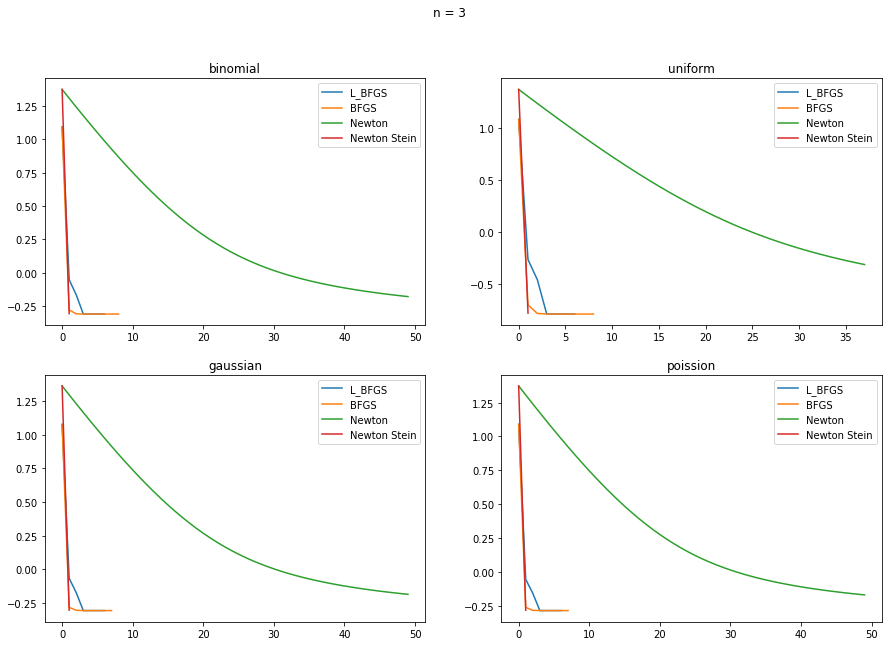

i= 1
i= 2
i= 3
i= 4


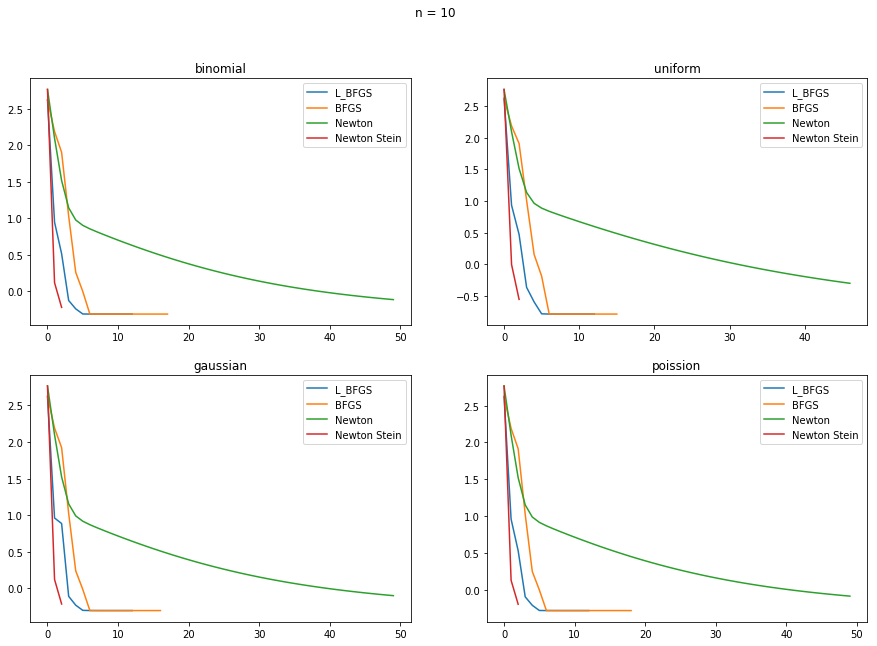

i= 1
i= 2
i= 3
i= 4


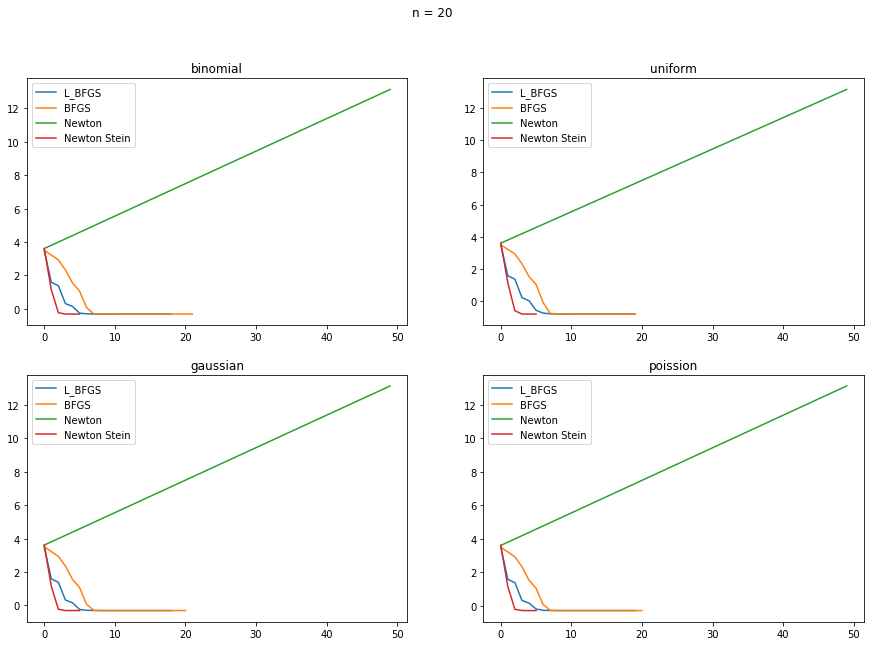

In [220]:
random_type = ['binomial', 'uniform', 'gaussian', 'poission']

for n in [3, 10, 20]:
    sample_size = 1000
    randomness_list = randomness(sample_size)
    sampledata = generate_random(n, sample_size)
    np.random.seed(5)
    beta = np.random.uniform(1,5,n).reshape(n,1)
    plt.figure(figsize = (15,10))
    plt.suptitle("n = %d"%n)
    i = 0
    for random_eps in randomness_list:
        i += 1
        print("i=",i)
        y = np.dot(sampledata,beta) + random_eps
        lst_BFGS = BFSG_method()
        lst_L_BFGS = L_BFGS_method()
        
        NewtonStein = Newton_Stein(y, sampledata,  np.ones((n,1)), int(sample_size*np.log(sample_size)), phi = phi_OLS)
        theta = np.ones(sampledata.shape[1])
        theta = theta.reshape(-1,1)
        Newton = gradientDescent(sampledata, y, theta , alpha = 0.02, numIterations = 50)
        plt.subplot(2,2,i)
        plt.title(random_type[i-1])
        plt.plot(range(len(lst_L_BFGS)),lst_L_BFGS, label = "L_BFGS")
        plt.plot(range(len(lst_BFGS)),lst_BFGS, label = "BFGS")
        plt.plot(range(len(Newton)),Newton, label = "Newton")
        plt.plot(range(len(NewtonStein)),NewtonStein[:50], label = "Newton Stein")
        plt.legend()
    plt.show()

i= 1
i= 2
i= 3
i= 4


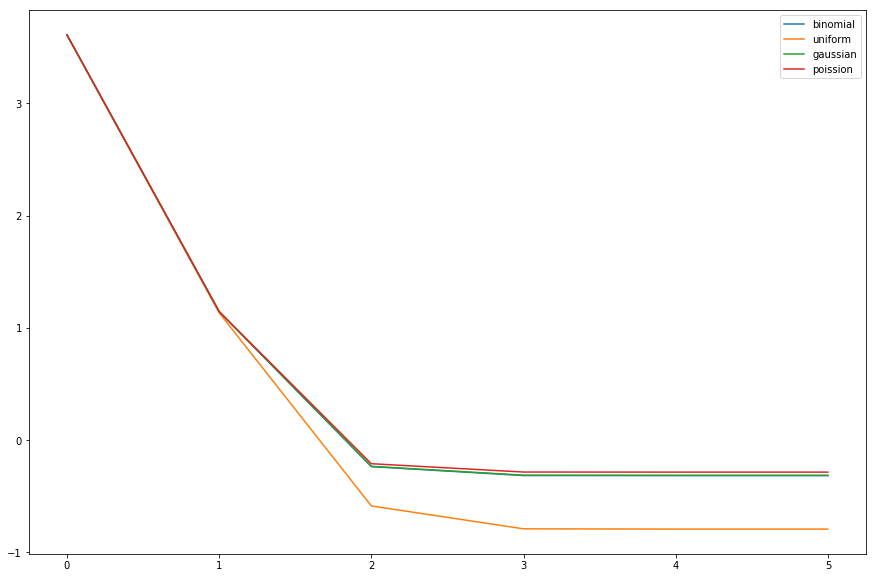

In [221]:

n = 20
sample_size = 1000
randomness_list = randomness(sample_size)
sampledata = generate_random(n, sample_size)
np.random.seed(5)
beta = np.random.uniform(1,5,n).reshape(n,1)
plt.figure(figsize = (15,10))
i = 0
for random_eps in randomness_list:
    i += 1
    print("i=",i)
    y = np.dot(sampledata,beta) + random_eps
    NewtonStein = Newton_Stein(y, sampledata,  np.ones((n,1)), int(sample_size*np.log(sample_size)), phi = phi_OLS)
    plt.plot(range(len(NewtonStein)),NewtonStein[:50], label = random_type[i-1])
plt.legend()
plt.show()